In [1]:
# packages
import pandas as pd
import numpy as np
# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#feature engineering
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score, KFold
from scipy import stats 
from scipy.stats import zscore, randint
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest
#pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#model
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor
#evaluation
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

**First download data from Zindi, then load data into notebook**

In [2]:
# download from https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge/data
# make sure it is saved as .csv
# read in the data
df = pd.read_csv("../../data/Train.csv", sep = ',')
df_test = pd.read_csv("../../data/Test.csv", sep=',')
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dropping extra columns**

In [3]:
columns_to_delete = ['Place_ID X Date', 
                     'target_min', 
                     'target_max',
                     'target_variance', 
                     'target_count', 
                     #removing all sensor data and zenith and azimuth angle data
                     'L3_NO2_sensor_altitude', 
                     'L3_NO2_sensor_azimuth_angle',
                     'L3_NO2_sensor_zenith_angle', 
                     'L3_NO2_solar_azimuth_angle',
                     'L3_NO2_solar_zenith_angle',                  
                     'L3_O3_sensor_azimuth_angle',
                     'L3_O3_sensor_zenith_angle', 
                     'L3_O3_solar_azimuth_angle',
                     'L3_O3_solar_zenith_angle',
                     'L3_CO_sensor_altitude', 
                     'L3_CO_sensor_azimuth_angle',
                     'L3_CO_sensor_zenith_angle', 
                     'L3_CO_solar_azimuth_angle',
                     'L3_CO_solar_zenith_angle',
                     'L3_HCHO_sensor_zenith_angle', 
                     'L3_HCHO_solar_azimuth_angle',
                     'L3_HCHO_sensor_azimuth_angle',
                     'L3_HCHO_solar_zenith_angle',
                     'L3_CLOUD_sensor_azimuth_angle', 
                     'L3_CLOUD_sensor_zenith_angle',
                     'L3_CLOUD_solar_azimuth_angle', 
                     'L3_CLOUD_solar_zenith_angle',
                     'L3_AER_AI_sensor_altitude', 
                     'L3_AER_AI_sensor_azimuth_angle',
                     'L3_AER_AI_sensor_zenith_angle', 
                     'L3_AER_AI_solar_azimuth_angle',
                     'L3_AER_AI_solar_zenith_angle',
                     'L3_SO2_sensor_azimuth_angle', 
                     'L3_SO2_sensor_zenith_angle',
                     'L3_SO2_solar_azimuth_angle', 
                     'L3_SO2_solar_zenith_angle', 
                     # removing columns with 80% missing values
                     'L3_CH4_sensor_azimuth_angle', 
                     'L3_CH4_sensor_zenith_angle',
                     'L3_CH4_solar_azimuth_angle', 
                     'L3_CH4_solar_zenith_angle',
                     'L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
                     'L3_CH4_aerosol_height',
                     'L3_CH4_aerosol_optical_depth'  
                    ]

df_reduced = df.drop(columns = columns_to_delete, axis = 1)

**Split training data into train and test set**

In [4]:
RSEED = 9 

# Define x/y
X = df_reduced
y = np.array(X.pop('target'))

# split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = RSEED)

**Check X_train dataframe**

In [5]:
X_train.head()

,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,...,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction
29510,2020-02-05,Y14BIVM,28.900001,78.533333,0.013429,22.587976,-1.387460,1.836352,0.000160,0.000113,...,31.595752,3116.409982,69441.588320,0.217149,-0.811269,NaN,NaN,NaN,NaN,NaN
19520,2020-04-03,L17O89H,51.900002,92.000000,0.017810,24.692560,0.739441,0.448384,0.000000,0.000000,...,7.640289,656.437231,94511.737305,0.215823,-2.384415,0.000000,0.000000,0.000000,0.000000,0.000000
8840,2020-01-15,9NOGUM2,15.371429,83.442857,0.005506,8.000691,-0.268914,-1.063077,0.000146,0.000206,...,6.067266,8249.585329,34893.039722,0.134485,-1.202729,-0.000348,0.225234,-0.000079,-1.875631,0.010434
11709,2020-03-05,D1OBVR6,16.566667,24.233333,0.005357,23.840250,3.434311,3.546778,0.000154,0.000264,...,5.467142,2429.454488,76566.328155,0.216301,-0.591315,0.000153,0.489687,0.000079,-1.305871,0.100380
10130,2020-02-14,BIWFBLL,5.020000,94.020002,0.001262,-12.742484,1.224210,2.544880,0.000209,0.000358,...,5.666527,2151.522680,77511.817124,0.627605,-1.138063,0.000916,0.293531,0.000155,-1.658998,0.095690


**Check for distribution and outliers in histograms for every feature**

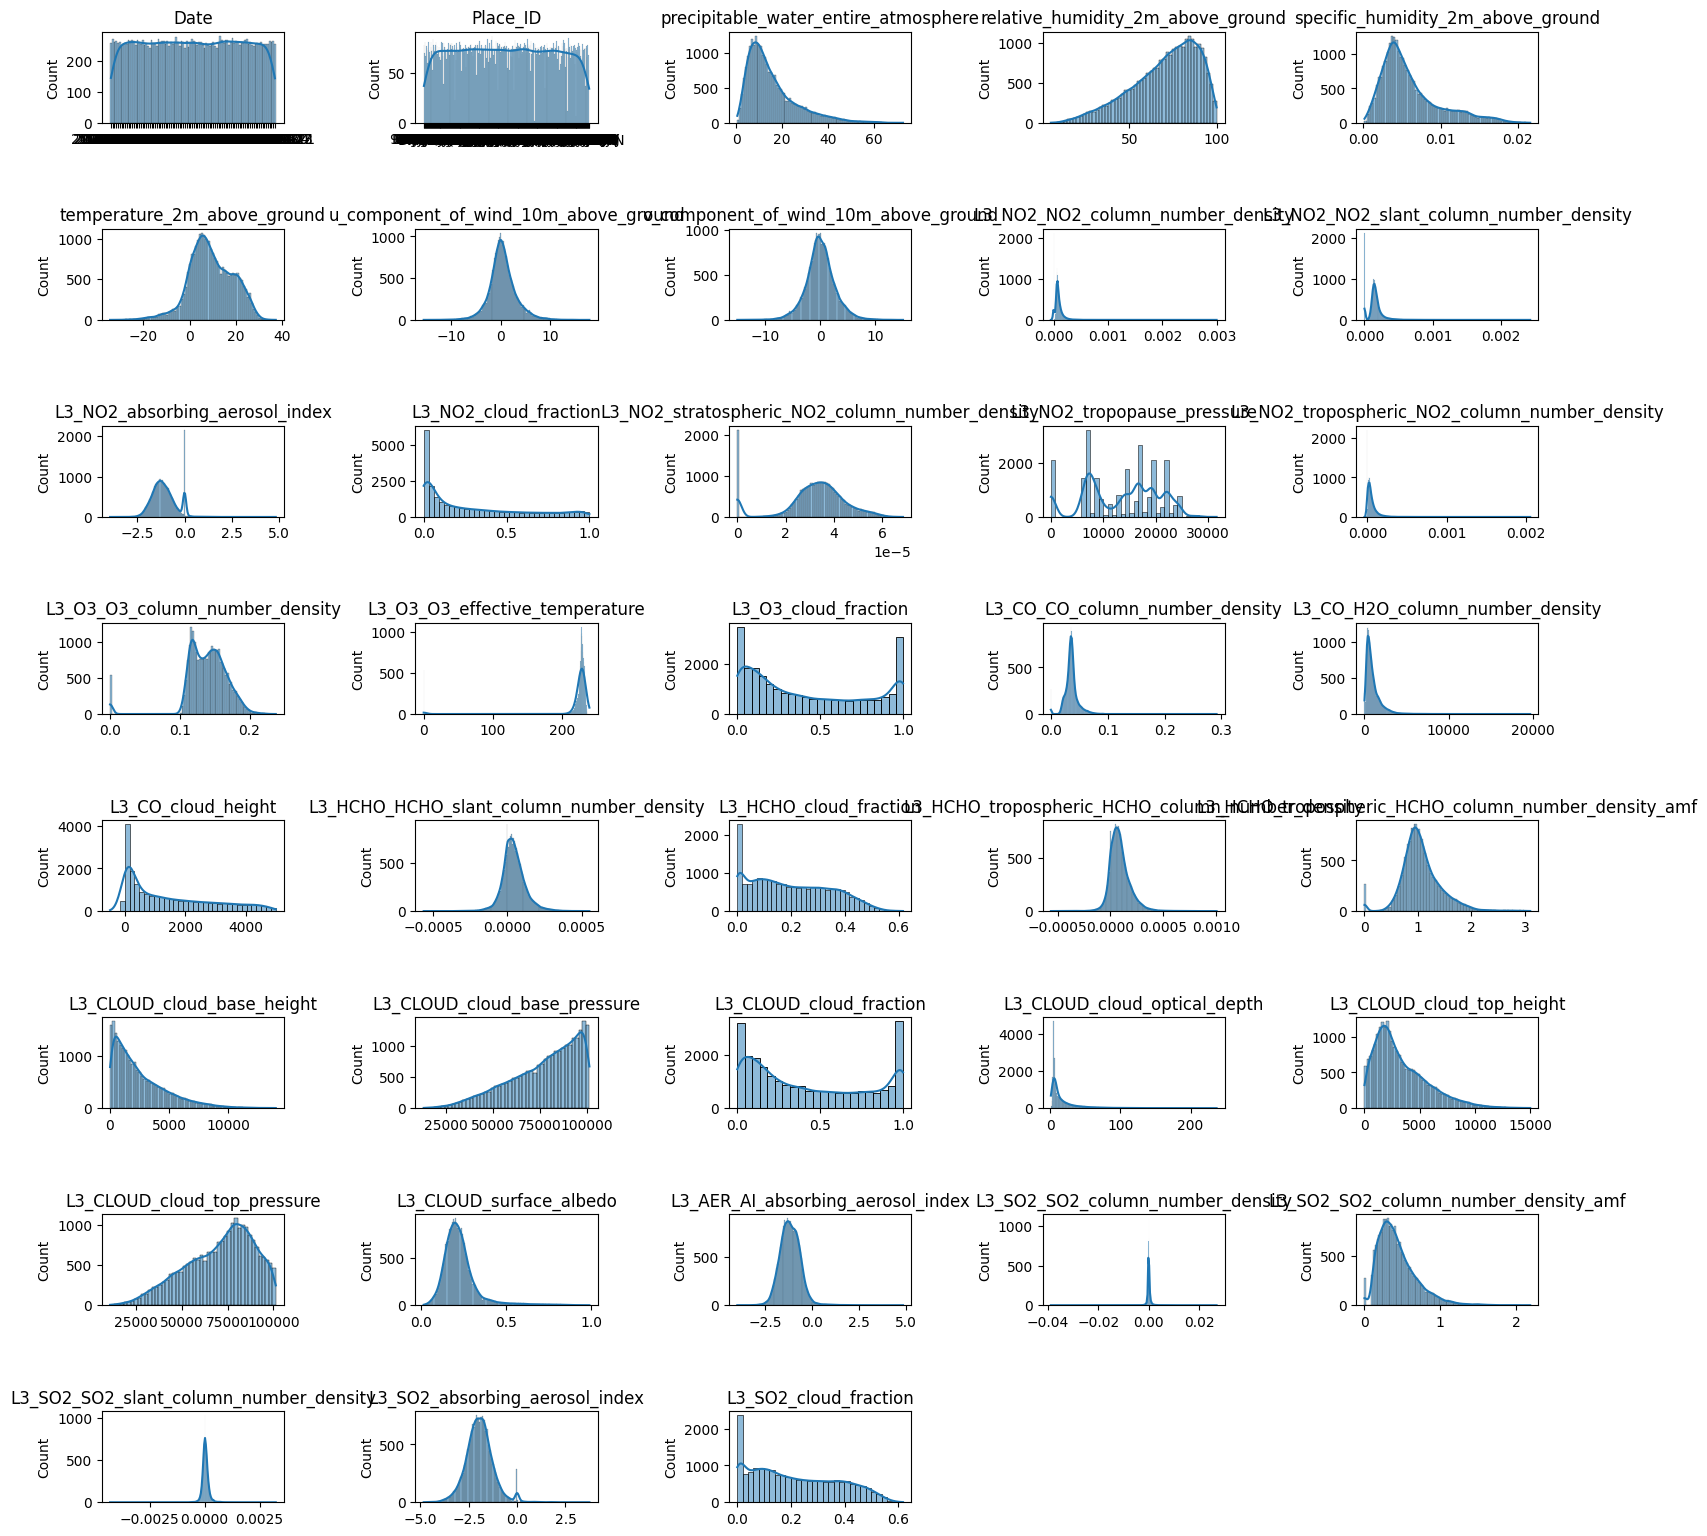

In [6]:
%run distribution.ipynb

plot_histograms(X_train)

With these plots we can detect the features with outliers. 

In [7]:
outliers =['L3_NO2_NO2_column_number_density', # right,
          'L3_NO2_NO2_slant_column_number_density', # right,
          'L3_NO2_absorbing_aerosol_index',
          'L3_NO2_stratospheric_NO2_column_number_density',
          'L3_NO2_tropospheric_NO2_column_number_density',
          'L3_O3_O3_column_number_density',
          'L3_O3_O3_effective_temperature',
          'L3_CO_CO_column_number_density',
          'L3_CLOUD_cloud_optical_depth',
          'L3_CLOUD_surface_albedo',
          'L3_AER_AI_absorbing_aerosol_index'
          ]

With the following code the outliers will be normalized by z-score.

In [8]:
class ReplaceOutliersWithMean(BaseEstimator, TransformerMixin):
    def __init__(self, zscore_threshold=3):
        self.zscore_threshold = zscore_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, np.ndarray):
            raise ValueError("Input must be a NumPy array.")
        
        for i in range(X.shape[1]):
            z_scores = zscore(X[:, i])
            outliers_mask = (z_scores > self.zscore_threshold) | (z_scores < -self.zscore_threshold)
            mean_value = np.mean(X[:, i])
            X[outliers_mask, i] = mean_value
        
        return X

**Pipeline for Feature Engineering and RandomForest Modeling**

For the analysis of data, all steps of preprocessing and modeling will be included in a pipeline. 
- Missing values will be imputed by interpolation of the previous and next value.
- Outliers will be treated with the z-score.
- All values will be scaled.

In [9]:
# check for missing values
X_train.isna().sum()

Date                                                      0
Place_ID                                                  0
precipitable_water_entire_atmosphere                      0
relative_humidity_2m_above_ground                         0
specific_humidity_2m_above_ground                         0
temperature_2m_above_ground                               0
u_component_of_wind_10m_above_ground                      0
v_component_of_wind_10m_above_ground                      0
L3_NO2_NO2_column_number_density                       1757
L3_NO2_NO2_slant_column_number_density                 1757
L3_NO2_absorbing_aerosol_index                         1757
L3_NO2_cloud_fraction                                  1757
L3_NO2_stratospheric_NO2_column_number_density         1758
L3_NO2_tropopause_pressure                             1758
L3_NO2_tropospheric_NO2_column_number_density          6898
L3_O3_O3_column_number_density                          224
L3_O3_O3_effective_temperature          

In [10]:
# Basic preprocessing pipeline 
preprocessing_base = Pipeline(steps=[
    ('imputing', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler())
])

In [11]:
# Outlier pipeline 
preprocessing_outliers = Pipeline(steps=[
    ('imputing', SimpleImputer(strategy='mean')),  
    ('remove outliers', ReplaceOutliersWithMean()),
    ('standard_scaler', StandardScaler())
])

In [12]:
preprocessing = ColumnTransformer([
    ('outlier transformation', preprocessing_outliers, outliers),
    ('transformations', preprocessing_base, X.columns.drop(['Place_ID', 'Date']+outliers)),
])

In [13]:
pipe_randFor = Pipeline([
    ('preprocessor', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=300,min_samples_split = 6,random_state=RSEED, max_features = 'sqrt',n_jobs=-1, verbose = 1))
])

In [14]:
pipe_randFor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.2s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('outlier transformation',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer()),
                                                                  ('remove '
                                                                   'outliers',
                                                                   ReplaceOutliersWithMean()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['L3_NO2_NO2_column_number_density',
                                                   'L3_NO2_NO2_slant_column_number_density',
                                                   'L3_NO2_absorbing_aerosol_index',
                                                   'L3_NO2_stratospheri...
       'L3_CLOUD_cloud_top_pressure', 'L3_SO2_SO2_column_number_density',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_SO2_SO2_slant_column_number_density',
       'L3_SO2_absorbing_aerosol_index', 'L3_SO2_cloud_fraction'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_features='sqrt', min_samples_split=6,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=9, verbose=1))])

In [15]:
y_train_predicted = pipe_randFor.predict(X_train)
print("RMSE train: {:.2f}".format(mean_squared_error(y_train, y_train_predicted, squared=False)))
y_test_predicted = pipe_randFor.predict(X_test)
print("RMSE test: {:.2f}".format(mean_squared_error(y_test, y_test_predicted, squared=False)))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


RMSE train: 15.57
RMSE test: 31.04


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


**Inspecting the RandomForest** 

To get an idea of the average amount of nodes in the random forest, we apply the functions `.estimators_`, `.tree_.node_count` and `.tree_.max_depth`.

In [16]:
# how many nodes of each tree
n_nodes = []
max_depths = []

for ind_tree in pipe_randFor.named_steps['regressor'].estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 10846
Average maximum depth 41


**Furthermore, the most important features are of interest, have a look at the top 30.** Therefore, the feature names and their importance needs to be extracted from the pipeline.
As the function used for outliers does not support the method `.get_feature_names_out()`, it is solved by the following function `get_column_names_from_ColumnTransformer()`. The importances of features in the Random Forest are accesses by `.feature_importance_`. In the last step these are plotted. 

In [17]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [18]:
transformers = pipe_randFor.named_steps['preprocessor'].transformers_
base_feature_names = transformers[1][1].named_steps['imputing'].get_feature_names_out(
    input_features=X.columns.drop(['Place_ID', 'Date'] + outliers)
)
outliers_feature_names = get_column_names_from_ColumnTransformer(preprocessing)

feature_names = np.concatenate([outliers_feature_names, base_feature_names])

In [19]:
importances = pipe_randFor.named_steps['regressor'].feature_importances_ 
indices = np.argsort(importances)

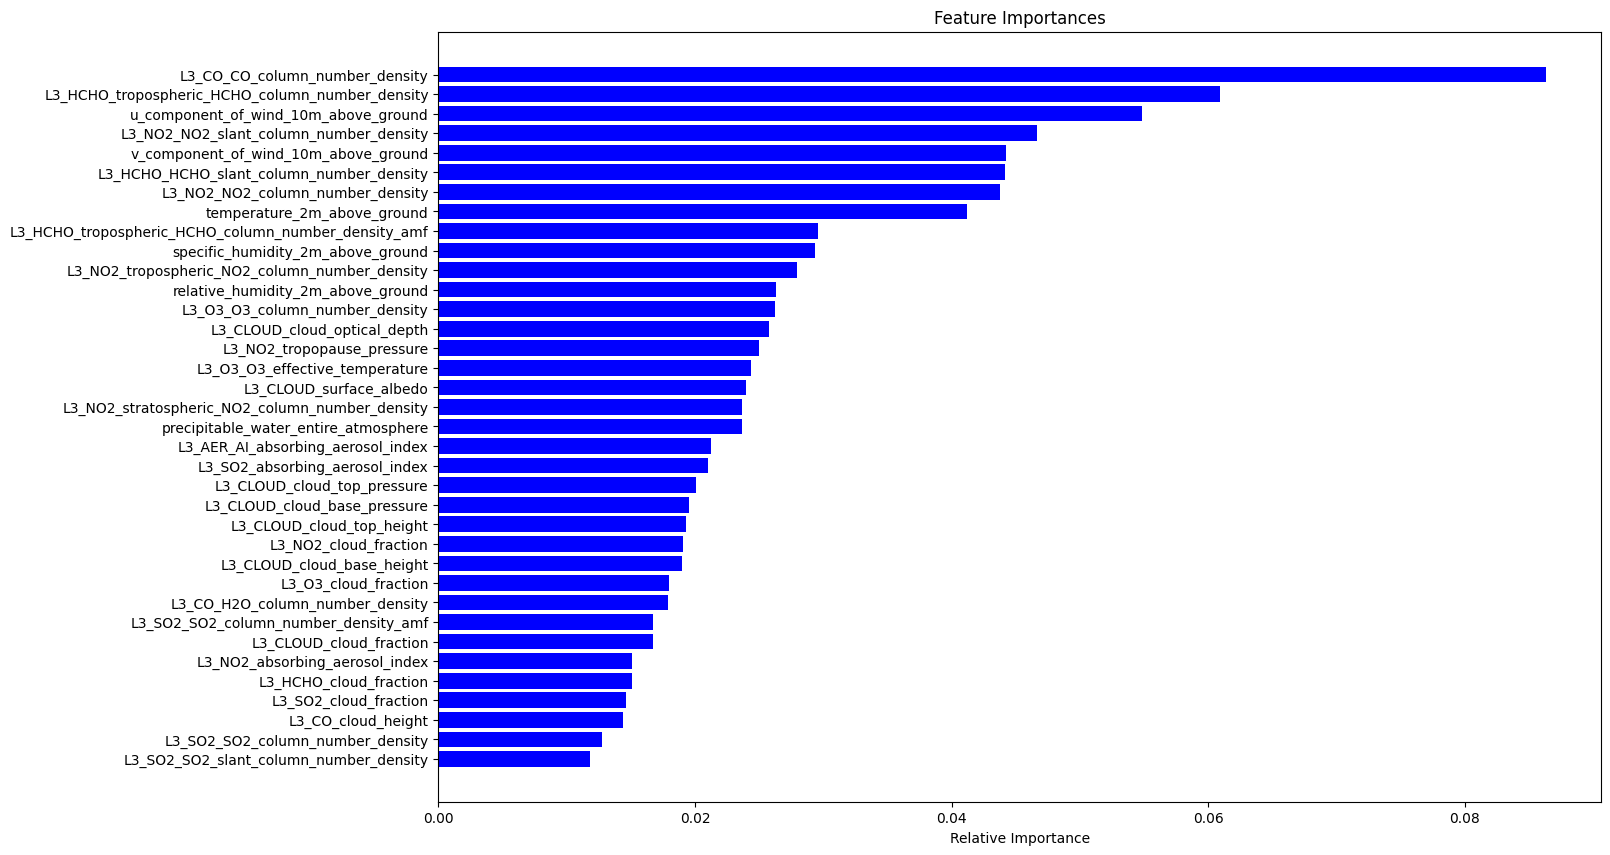

In [20]:
#plot results
plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The most important features are therefore CO, HCHO and NO2 density, the horizontal and vertical component of the wind. As the angles of the sensors were excluded in this analysis, no further feature selection will be performed.

**Adapt to real test data**

In [21]:
y_test_real = pipe_randFor.predict(df_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.4s finished


In [22]:
results_df = pd.DataFrame({
    'Date X Place_ID': df_test['Place_ID'] + " X " + df_test['Date'],
    'target': y_test_real.astype(int)
})

In [23]:
results_df.to_csv('submission.csv',sep = ',', index= False)

**Changing the Model in the Pipeline for Stacking Ensemble Model**

In [24]:
# Stacking Ensemble Model consisting of three basic estimators and one final estimator.
estimators = [
    ('rf', RandomForestRegressor(random_state = RSEED)),
    ('knn', KNeighborsRegressor()),
    ('lin', Ridge())
]

final_estimator = RandomForestRegressor(random_state = RSEED)
stackReg = StackingRegressor(estimators = estimators, final_estimator = final_estimator)

In [25]:
# Set parameters for the random search
param_dist = {
    'final_estimator__n_estimators': randint(10, 200),
    'final_estimator__max_depth': randint(1, 20),
    'final_estimator__min_samples_split': randint(2, 20),
    'final_estimator__min_samples_leaf': randint(1, 20),
    'final_estimator__max_features':['sqrt'],
    
    'rf__n_estimators': randint(10, 200),
    'rf__max_depth': randint(1, 20),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
    'rf__max_features':['sqrt'],
    
    'knn__n_neighbors': randint(1, 20),
    'knn__weights':['uniform', 'distance'],
    'knn__p':[1,2,3],
    
    'lin__alpha': [0.1, 1.0, 10.0],
    
}

In [26]:
# Instantiate Random search and define the metric to optimize 
stack_search = RandomizedSearchCV(stackReg, param_dist, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

pipe_stacked = Pipeline([
    ('preprocessor', preprocessing),
    ('model', stack_search)
])

In [27]:
pipe_stacked.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Jennifer\Documents\Job\Spiced\machine_learning\air_pollution_prediction\.venv\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('outlier transformation',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer()),
                                                                  ('remove '
                                                                   'outliers',
                                                                   ReplaceOutliersWithMean()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['L3_NO2_NO2_column_number_density',
                                                   'L3_NO2_NO2_slant_column_number_density',
                                                   'L3_NO2_absorbing_aerosol_index',
                                                   'L3_NO2_stratospheri...
                                                         'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ABDEB2FE50>,
                                                         'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ABDF71AB10>,
                                                         'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ABDF738B10>},
                                    random_state=9, scoring='roc_auc',
                                    verbose=5))])

In [28]:
y_pred_train_sel = pipe_stacked.predict(X_train)
print("RMSE train: {:.2f}".format(mean_squared_error(y_train, y_pred_train_sel, squared=False)))
y_pred_test_sel = pipe_stacked.predict(X_test)
print("RMSE test: {:.2f}".format(mean_squared_error(y_test, y_pred_test_sel, squared=False)))

RMSE train: 29.25
RMSE test: 32.59


**Adapt to test file**

In [29]:
y_test_real_stacked = pipe_stacked.predict(df_test)

In [30]:
results_df = pd.DataFrame({
    'Date X Place_ID': df_test['Place_ID'] + " X " + df_test['Date'],
    'target': y_test_real_stacked.astype(int)
})

In [31]:
results_df.to_csv('submission_stacked.csv',sep = ',', index= False)

**Save the model**

In [33]:
# store model
from joblib import dump, load
dump(pipe_stacked, 'air_pollution_model.joblib')

['air_pollution_model.joblib']

**Visualize some main results of the data set**

In [34]:
# this can be done for train/test data
analyse_results_df = pd.DataFrame({
    'Date': X_train['Date'],
    'Place_ID': X_train['Place_ID'],    
    'target': y_train  
})

Air_Quality_Category
Unhealthy                   146
Moderate                    103
Unhealthy for Sensitives     80
Very Unhealthy                9
Good                          2
Hazardous                     0
Name: count, dtype: int64


Text(0, 0.5, 'Count')

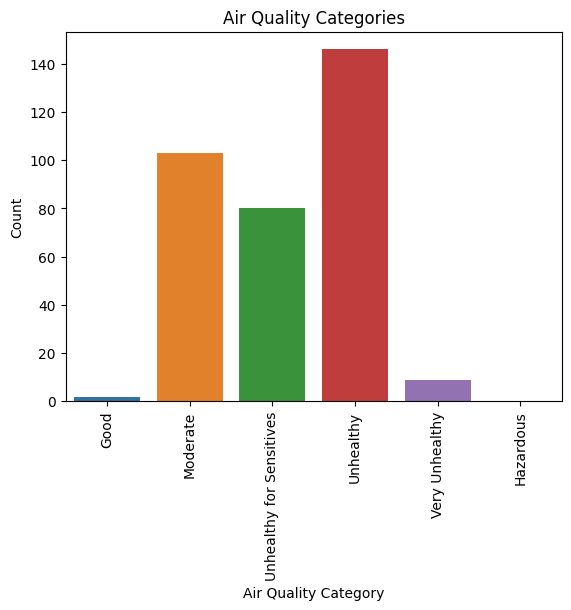

In [35]:
# Plot sum of Place_IDs per USA AQI Level 
average_category = analyse_results_df.groupby('Place_ID').mean('target').sort_values('target', ascending=False)

average_category['Air_Quality_Category'] = pd.cut(
    average_category['target'],
    bins=[-np.inf, 12, 35.4, 55.4, 150.4, 250.4, np.inf],
    labels=['Good', 'Moderate', 'Unhealthy for Sensitives', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
)

print(average_category['Air_Quality_Category'].value_counts())

sns.countplot(x='Air_Quality_Category', data=average_category)
plt.title('Air Quality Categories')
plt.xticks(rotation='vertical')
plt.xlabel('Air Quality Category')
plt.ylabel('Count')